In [4]:
sequances=[0,1,2,3,4,5,6,7,8,9]

InputFilePath='/home/amar/Desktop/KITTI VO'
LeftPath='image_0'
RightPath='image_1'
GTFILE=InputFilePath+'/poses'


In [3]:
import numpy as np
import cv2
import timeit
import matplotlib.pyplot as plt
import glob

In [5]:
def getAbsoluteScale(f, frame_id):
    ''' Gets the Euclideian distance between the current ground thruth and the former ground thruth.'''
    x_pre, y_pre, z_pre = f[frame_id-1][3], f[frame_id-1][7], f[frame_id-1][11]
    x    , y    , z     = f[frame_id][3], f[frame_id][7], f[frame_id][11]
    scale = np.sqrt((x-x_pre)**2 + (y-y_pre)**2 + (z-z_pre)**2)
    return x, y, z, scale
      
def featureTracking(img_1, img_2, p1):

    lk_params = dict( winSize  = (21,21),
                      maxLevel = 3,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
    
    ## Only Keep matching points
    st = st.reshape(st.shape[0])
    p1 = p1[st==1]
    p2 = p2[st==1]

    return p1,p2

def featureDetection():
    fast=cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
    return fast

def GetGroundTruth(file='/home/amar/Documents/DataSets/KittiDataset/2011_09_26/poses/06.txt'):
    return np.genfromtxt(file,dtype=None,delimiter='')

def getImages(i):
    return cv2.imread('/home/amar/Documents/DataSets/KittiDataset/2011_09_26/2011_09_26_drive_0009_sync/image_00/data{0:06d}.png'.format(i), 0)

def getK():
    return   np.array([[7.188560000000e+02, 0, 6.071928000000e+02],
              [0, 7.188560000000e+02, 1.852157000000e+02],
              [0, 0, 1]])


def LoadInData(InputPath,Extention=''):
    stuff=[]
    for file in sorted(glob.glob(f'{InputPath}/*{Extention}')):
        img=cv2.imread(file,0)
        stuff.append(img)
    return stuff

In [19]:
AvargeErrorDict={'00':[],'01':[],'02':[],'03':[],'04':[],'05':[],'06':[],'07':[],'08':[],'09':[]}




for Sequance in range(10):

    
    # load data


    LeftImagePath=InputFilePath+f'/0{Sequance}/'+LeftPath
    GroundTruthFile=GTFILE+f'/0{Sequance}.txt'

    LeftDataSet=LoadInData(LeftImagePath,'.png')
    ground_truth =GetGroundTruth(GroundTruthFile)
    
      # Set Paramters 

    #Camera parameters
    fc = 718.8560
    pp = (607.1928, 185.2157)
    K  = getK()

    #initialize some parameters
    MAX_FRAME 	  = len(LeftDataSet)
    MIN_NUM_FEAT  = 2000

    detector = featureDetection()

    traj = np.zeros((600, 600, 3), dtype=np.uint8) 

    maxError = 0
    totalError=0
    
    
    #initialization

    gray_1 = LeftDataSet[0]
    gray_2 = LeftDataSet[1]

    #find the KeyPoints

    p1       = detector.detect(gray_1)
    p1       = np.array([ele.pt for ele in p1],dtype='float32')
    p1, p2   = featureTracking(gray_1, gray_2, p1)

    # Essential Matrix Decompastion

    E, mask = cv2.findEssentialMat(p2, p1, fc, pp, cv2.RANSAC,0.999,1.0,None); 
    _, R, t, mask = cv2.recoverPose(E, p2, p1,focal=fc, pp = pp);

    # T1 ->T

    preFeature = p2
    preImage   = gray_2

    # Update Trajectory

    R_f = R
    T = t
    
    # Main Loop

    for numFrame in range(2, MAX_FRAME):


        if (len(preFeature) < MIN_NUM_FEAT):
            feature   = detector.detect(preImage)
            preFeature = np.array([ele.pt for ele in feature],dtype='float32')


        curImage =LeftDataSet[numFrame]


        kp1 = detector.detect(curImage);
        preFeature, curFeature = featureTracking(preImage, curImage, preFeature)
        E, mask = cv2.findEssentialMat(curFeature, preFeature, fc, pp, cv2.RANSAC,0.999,1.0); 
        _, R, t, mask = cv2.recoverPose(E, curFeature, preFeature, focal=fc, pp = pp);

        truth_x, truth_y, truth_z, absolute_scale = getAbsoluteScale(ground_truth, numFrame)

        if absolute_scale > 0.1:  
            T = T + absolute_scale*R_f.dot(t)
            R_f = R.dot(R_f)

        preImage, preFeature = curImage, curFeature


        # Error Caculation
        curError = np.sqrt((T[0]-truth_x)**2 + (T[1]-truth_y)**2 + (T[2]-truth_z)**2)
        totalError+=curError

        if (curError > maxError): maxError = curError
        
        AvargeErrorDict[f'0{Sequance}'].append((curError/numFrame))
        
        # Visualization of the result
        draw_x, draw_y = int(0.5*T[0]) + 300, int(0.5*T[2]) + 100;
        draw_tx, draw_ty = int(0.5*truth_x) + 300, int(0.5*truth_z) + 100



        cv2.circle(traj, (draw_x, draw_y) ,1, (0,0,255), 2);
        cv2.circle(traj, (draw_tx, draw_ty) ,1, (255,0,0), 2);

        cv2.rectangle(traj, (10, 30), (550, 50), (0,0,0), cv2.FILLED);
        text = f"Coordinates: x ={str(float(T[0]))[0:7]}m y = {str(float(T[2]))[0:7]}m"  
        cv2.putText(traj, text, (10,50), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1, 8);
        
        if numFrame==MAX_FRAME-1: 
            cv2.imwrite(f'Trajectory Map 0{Sequance}.png',traj)
            print(f'Image Sequance: 0{Sequance} Completed')

Image Sequance: 00 Completed
Image Sequance: 01 Completed
Image Sequance: 02 Completed
Image Sequance: 03 Completed
Image Sequance: 04 Completed
Image Sequance: 05 Completed
Image Sequance: 06 Completed
Image Sequance: 07 Completed
Image Sequance: 08 Completed
Image Sequance: 09 Completed


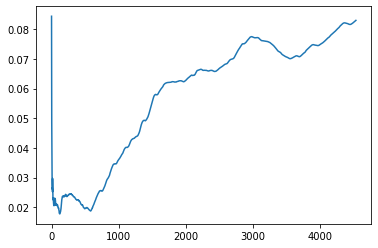

In [20]:
fig=plt.ax

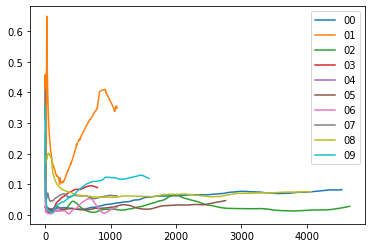

In [35]:
# PLOT AND SAVE AVARGE ERROR
for key in AvargeErrorDict.keys():
    plt.plot(AvargeErrorDict[key],label=key)
plt.legend()

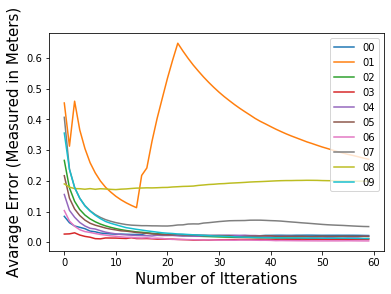

In [42]:
plt.xlabel('Number of Itterations', fontsize=15)
plt.ylabel('Avarage Error (Measured in Meters)',fontsize=15)
for key in AvargeErrorDict.keys():plt.plot(AvargeErrorDict[key][0:60],label=f'{key}')
plt.legend()
